### Reproduce Figure 1 in Vecellio et al 2023


In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from shapely import geometry
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# read population data for year 2050 under SSP2 scenario
pop_path='/scratch/brown/kong97/PNAS_paper_data/ssp2_2050.nc'
pop=xr.open_dataset(pop_path).ssp2_2050

# The number of population expericing hot hours longer than 1 week, 1 month and 3 months.
person_many_hours=xr.open_dataset('/scratch/brown/kong97/PNAS_paper_data/SSP_2050_persons_under_many_hothours_tot.nc')

def read_hothours(X):
    # read hot-hours data for +XC warming compared with preindustrial period
    path='/scratch/brown/kong97/PNAS_paper_data/Tw_tot_hothours_preindustrial_'+str(X)+'C.nc'
    result=xr.open_dataset(path).hours
    return result

# read hot-hours data for 1.5, 2, 3, 4C degree warming compared with preindustrial period
hothours={}
for X in [1.5,2,3,4]:
    tmp=read_hothours(X)*3 # multiply 3 since the original hot-hours are calculated from 3-hourly data
    hothours[X]=tmp
hothours=xr.concat(list(hothours.values()),dim='X')
hothours['X']=[1.5,2,3,4]

In [10]:
# interpolate NaN values around 0E
def interp(data):
    data2=data.copy()
    longitude=data.lon
    longitude=xr.where(longitude>180,longitude-360,longitude)
    data2['lon']=longitude
    data2=data2.sortby('lon')
    loc=0
    locnew=np.array([loc-1,loc-0.75,loc-0.5,loc-0.25,loc,loc+0.25,loc+0.5,loc+0.75,loc+1])
    tmp=data2.drop_sel(lon=locnew)
    tmp2=tmp.interp(lon=data2.lon.values)
    longitude2=tmp2.lon
    longitude2=xr.where(longitude2<0,longitude2+360,longitude2)
    tmp2['lon']=longitude2
    return tmp2.sortby('lon')

In [4]:
# define colormap1
color1=np.array([
    [225,225,225],
    [255, 245, 204],
    [255, 230, 112],
    [255, 204,  51],
    [255, 175,  51],
    [255, 153,  51],
    [255, 111,  51],
    [255,  85,   0],
    [230,  40,  30],
    [200,  30,  20]])
cmap1=mpl.colors.ListedColormap(color1/255.)

# define colormap2
color2=np.array([
    [255,255,229],
    [255,247,188],
    [254,227,145],
    [254,196,79],
    [254,153,41],
    [236,112,20],
    [204,76,2],
    [153,52,4],
    [119.,42.,5.33333333],
    [103,0,31],
    [201,148,199]
])
cmap2=mpl.colors.ListedColormap(color2/255.)

In [5]:
# define region lat-lon ranges

# South Asia
SAS={'lat1':7,
   'lat2':35,
   'lon1':63,
   'lon2':95}

# East Asia
EAS={'lat1':7,
   'lat2':56,
   'lon1':100,
   'lon2':137}

# West Africa
WAF={'lat1':-3,
   'lat2':25,
   'lon1':-15,
   'lon2':30}

# Middle East
ME={'lat1':8,
   'lat2':36,
   'lon1':35,
   'lon2':60}

# North America
NAM={'lat1':10,
   'lat2':48,
   'lon1':-120,
   'lon2':-77}
regions=[SAS,EAS,WAF,ME,NAM]

In [9]:
# add boxes representing certain regions
def add_sub_region_box(ax, subregion):
    geom = geometry.box(minx=subregion['lon1'],maxx=subregion['lon2'],miny=subregion['lat1'],maxy=subregion['lat2'])
    center_lat=(subregion['lat1']+subregion['lat2'])/2
    center_lon=(subregion['lon1']+subregion['lon2'])/2
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      facecolor ='none',edgecolor='k',linewidth=0.5)
    return ax

# subplot to make each individual map
def subplot(data,axis,norm,cmap,LON,LAT,landmask,dointerp,add_region):
    if dointerp:
        g=axis.pcolormesh(LON, LAT,data.pipe(interp).where(landmask==0),
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,norm=norm,rasterized=True) 
    else:
        g=axis.pcolormesh(LON, LAT,data.where(landmask==0),
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,norm=norm,rasterized=True) 
    if add_region:
        for region in regions:
            add_sub_region_box(axis, region)
    axis.coastlines(linewidth=0.5,resolution='50m') # add coastlines
    axis.set_title('')
    axis.set_extent([-169.999,189.999,-60,75]) # set extent of the map to exclude high latitudes
    return g

# curve plot
def curve(x,y,axis,c,linestyle,label,marker,linewidth):
    g=axis.plot(x,y,color=c,linestyle=linestyle,label=label,marker=marker,linewidth=linewidth)
    return g

def plot(data,pop,person_many_hours):
    fig = plt.figure(figsize=[12,10])
    levels1=[0,3,8,24,56,112,168,240,480,720]
    norm1=mpl.colors.BoundaryNorm(levels1,ncolors=len(levels1),extend='max')
    clabel1='Annual hot hours'
    
    levels2=[0,500,1000,5000,10000,20000,40000,60000,80000,100000,200000]
    norm2=mpl.colors.BoundaryNorm(levels2,ncolors=len(levels2),extend='max')
    clabel2='Population ($10^4$)'
    
    LON1,LAT1=np.meshgrid(data.lon.values,data.lat.values)
    landmask1= regionmask.defined_regions.natural_earth.land_110.mask(data,lon_name="lon",lat_name="lat")
    
    LON2,LAT2=np.meshgrid(pop.lon.values,pop.lat.values)
    landmask2= regionmask.defined_regions.natural_earth.land_110.mask(pop,lon_name="lon",lat_name="lat")
    
    Xs=[1.5,2,3,4]
    anno_opts = dict(xy=(0, 1.05), xycoords='axes fraction',va='baseline', ha='left')
    annots=['a','b','c','d','e','f']
    
    gs_top = plt.GridSpec(3, 2, top=0.95,hspace=-0.3,wspace=0.05)
    gs_base = plt.GridSpec(5, 4,width_ratios=[2.38,0,1.9,0.1],height_ratios=[4,4,1,2.8,0.2],hspace=0,wspace=0.15)

    ax1 = fig.add_subplot(gs_top[0,0],projection=ccrs.Robinson(central_longitude=10))
    ax2 = fig.add_subplot(gs_top[0,1],projection=ccrs.Robinson(central_longitude=10))
    ax3 = fig.add_subplot(gs_top[1,0],projection=ccrs.Robinson(central_longitude=10))
    ax4 = fig.add_subplot(gs_top[1,1], projection=ccrs.Robinson(central_longitude=10))
    ax5 = fig.add_subplot(gs_base[8:17], projection=ccrs.Robinson(central_longitude=10))
    ax6 = fig.add_subplot(gs_base[14])
    
    axes=[ax1,ax2,ax3,ax4]
    for i in range(4):
        tmp=data.sel(X=Xs[i])
        add_region=True if i==0 else False
        g=subplot(tmp,axes[i],norm1,cmap1,LON1,LAT1,landmask1,True,add_region)
        axes[i].annotate(annots[i], **anno_opts,fontsize=16)                    
    
    h=subplot(pop,ax5,norm2,cmap2,LON2,LAT2,landmask2,False,False)
    ax5.annotate('e', **anno_opts,fontsize=16)
    
    curve(person_many_hours.X.values,
          person_many_hours.persons.isel(thre=0).mean('model').values/1e9,
          ax6,'k','solid','1 week','o',1.5)
    curve(person_many_hours.X.values,
          person_many_hours.persons.isel(thre=3).mean('model').values/1e9,
          ax6,'b','solid','1 month','o',1.5)
    curve(person_many_hours.X.values,
          person_many_hours.persons.isel(thre=-1).mean('model').values/1e9,
          ax6,'r','solid','3 months','o',1.5)
    ax6.fill_between(person_many_hours.X.values,
                     person_many_hours.persons.isel(thre=0).quantile(0.1,'model').values/1e9,
                     person_many_hours.persons.isel(thre=0).quantile(0.9,'model').values/1e9,
                     alpha=0.2,color='black')
    ax6.fill_between(person_many_hours.X.values,
                     person_many_hours.persons.isel(thre=3).quantile(0.1,'model').values/1e9,
                     person_many_hours.persons.isel(thre=3).quantile(0.9,'model').values/1e9,
                     alpha=0.2,color='b')
    ax6.fill_between(person_many_hours.X.values,
                     person_many_hours.persons.isel(thre=-1).quantile(0.1,'model').values/1e9,
                     person_many_hours.persons.isel(thre=-1).quantile(0.9,'model').values/1e9,
                     alpha=0.2,color='r')
    
    ax6.set_xlabel('Global warming target ($^\circ$C)',fontsize=12)
    ax6.set_ylabel('persons (billions)',fontsize=12)
    ax6.set_xlim([0.97,4.03])
    ax6.tick_params(axis='both', which='major', labelsize=12)
    ax6.legend(fontsize=12,loc='upper left')
    ax6.annotate('f', **anno_opts,fontsize=16)
    ax6.yaxis.set_ticks_position("right")
    ax6.yaxis.set_label_position("right")
        
    cb1=fig.colorbar(g,ax=(ax1,ax2,ax3,ax4),orientation='horizontal',pad=0.04,shrink=0.75,fraction=.08,aspect=50,ticks=levels1)
    cb1.set_label(label=clabel1, size=14)
    cb1.ax.tick_params(labelsize=12)
    
    cb2=fig.colorbar(h,ax=ax5,orientation='horizontal',pad=0.04,shrink=0.9,fraction=.08,aspect=50,ticks=levels2)
    cb2.set_label(label=clabel2, size=14)
    cb2.ax.tick_params(labelsize=12)
    cb2.ax.set_xticklabels(['0','0.05','0.1','0.5','1','2','4','6','8','10','20']) 


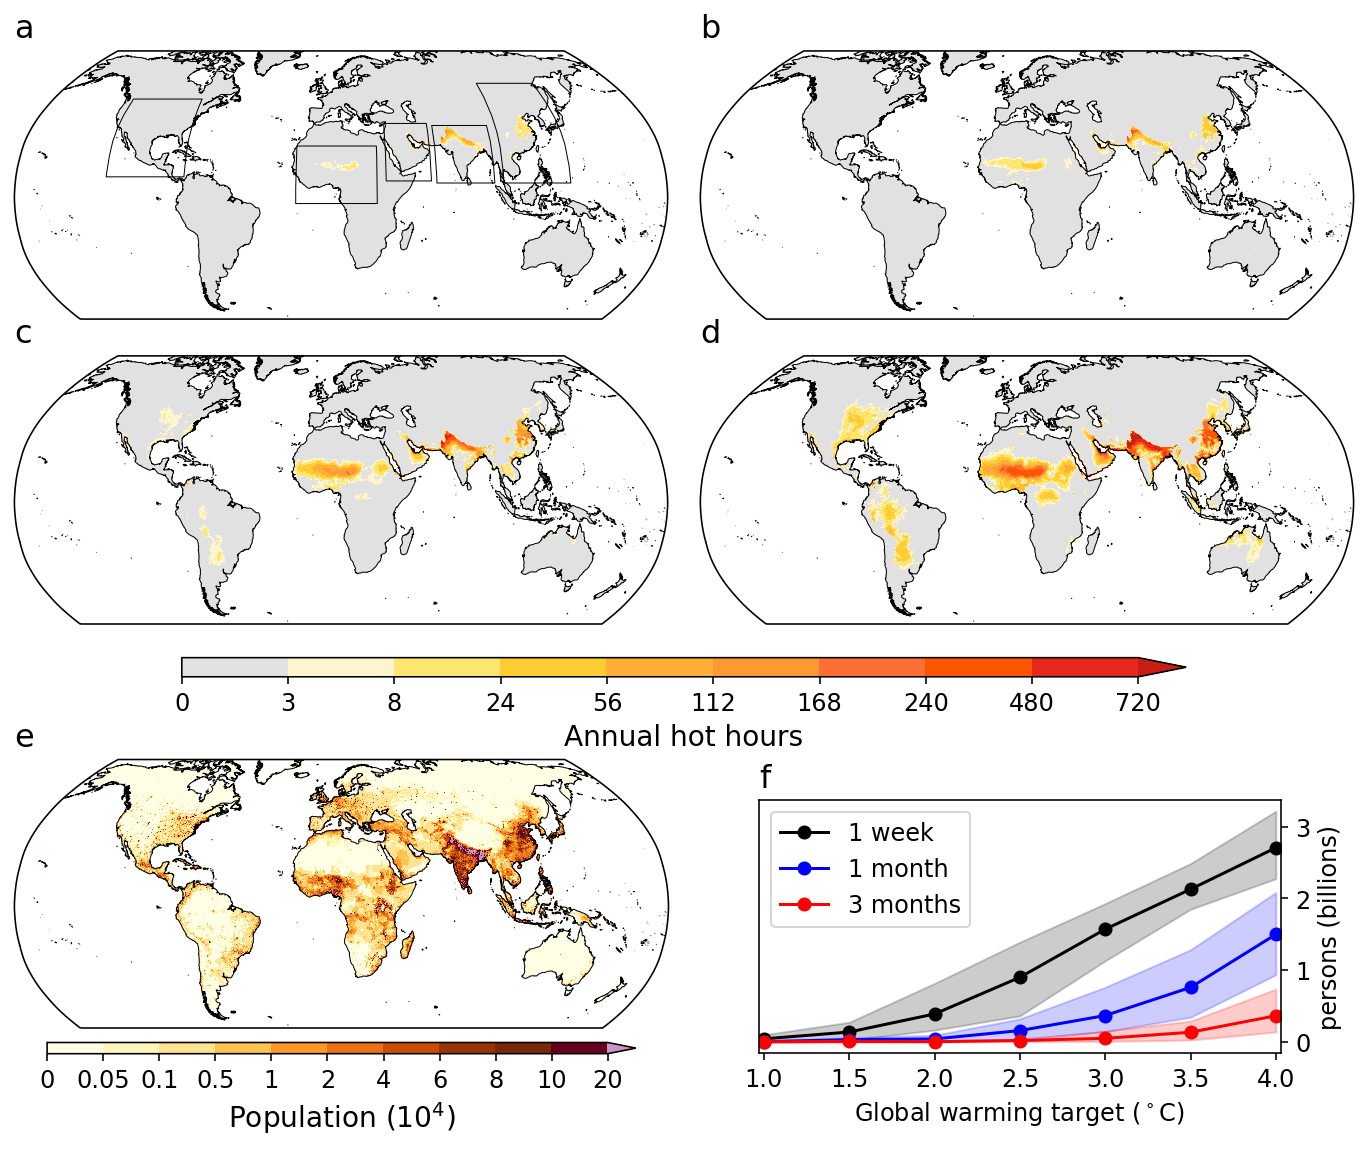

In [11]:
plot(hothours,pop,person_many_hours)